# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

import numpy as np
from scipy import stats
from datetime import timedelta

In [3]:
today = datetime.datetime.now() - datetime.timedelta(days = 1) #minus 1 day to mitigate inconsistency
tomorrow = today + datetime.timedelta(days =2)

today

datetime.datetime(2024, 11, 21, 8, 59, 58, 155766)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159320
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [5]:
feature_view = fs.get_feature_view(
    name='air_quality_fv_improved',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_improved",
    version=3,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='8.615246E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float...
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
aq_fg = fs.get_feature_group(
    name='air_quality_improved',
    version=1,
)
#aq_batch_data = aq_fg.filter(aq_fg.date > today).read()
aq_batch_data = aq_fg.read()
aq_batch_data = aq_batch_data.sort_values('date')
aq_batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.71s) 


,date,pm25,country,city,street,url,pm25_rolling_mean_3d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_mean_7d,...,pm25_ema_7d,pm25_trend_3d,pm25_volatility_3d,pm25_trend_7d,pm25_volatility_7d,pm25_trend_14d,pm25_volatility_14d,pm25_zscore,pm25_percentile,pm25_skew_7d
39,2021-12-28 00:00:00+00:00,56.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,64.333333,8.504901,73.0,74.571429,...,69.305078,-9.333333,0.132201,2.714286,0.193069,-0.714286,0.156008,-1.544399,0.043327,0.177380
923,2021-12-29 00:00:00+00:00,71.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,66.666667,9.291573,73.0,73.285714,...,69.728808,-3.333333,0.139374,1.000000,0.194209,0.392857,0.152746,-0.851042,0.221116,0.464423
572,2021-12-30 00:00:00+00:00,77.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,68.000000,10.816654,77.0,71.000000,...,71.546606,0.500000,0.159068,-1.928571,0.163040,0.892857,0.151308,-0.573700,0.321713,0.629484
346,2021-12-31 00:00:00+00:00,60.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,69.333333,8.621678,77.0,66.428571,...,68.659955,2.500000,0.124351,-5.428571,0.112939,0.428571,0.160526,-1.359504,0.076693,0.056377
298,2022-01-01 00:00:00+00:00,50.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,62.333333,13.650397,77.0,64.428571,...,63.994966,-2.166667,0.218990,-6.928571,0.151773,0.500000,0.173091,-1.821742,0.018924,-0.151944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2024-11-11 00:00:00+00:00,71.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,78.333333,11.846237,92.0,81.428571,...,78.163566,-3.500000,0.151229,7.357143,0.111174,5.750000,0.197360,-0.851042,0.221116,0.071398
954,2024-11-12 00:00:00+00:00,88.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,77.000000,9.539392,88.0,82.714286,...,80.703118,-6.833333,0.123888,7.357143,0.112271,5.750000,0.197360,-0.065238,0.493526,-0.318823
908,2024-11-13 00:00:00+00:00,113.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,90.666667,21.126603,113.0,88.000000,...,88.973828,3.000000,0.233014,7.357143,0.160304,5.750000,0.197360,1.090356,0.837649,0.429396
1004,2024-11-20 00:00:00+00:00,75.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,74.000000,12.529964,86.0,87.142857,...,84.542559,-18.833333,0.169324,-8.785714,0.308091,-0.928571,0.234294,-0.665056,0.287276,0.235102


In [9]:
def calculate_multiple_future_features(historical_data: pd.DataFrame, days_ahead: int = 7) -> pd.DataFrame:
    """
    Calculate PM2.5 features for multiple future dates based on historical patterns,
    starting from the day after the last date in the historical data.
    
    Parameters:
    historical_data: DataFrame with 'date' column and required columns
    days_ahead: number of days to predict ahead (default: 7)
    
    Returns:
    DataFrame with features for all future dates
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    from datetime import timedelta
    
    # Create a copy to avoid modifying the original
    df = historical_data.copy()
    
    # Set the date as index if it's not already
    if 'date' in df.columns:
        df = df.set_index('date')
    
    # Make sure data is sorted by date
    df = df.sort_index()
    
    # Get the last date from the data and set start date to the next day
    last_date = df.index.max()
    start_date = last_date + pd.Timedelta(days=1)
    
    # Generate future dates
    future_dates = pd.date_range(start=start_date, periods=days_ahead, freq='D')
    future_features = pd.DataFrame(index=future_dates)
    
    # Calculate last known values and patterns
    last_values = {
        'rolling_mean_3d': df['pm25'].rolling(window=3).mean().iloc[-1],
        'rolling_std_3d': df['pm25'].rolling(window=3).std().iloc[-1],
        'rolling_max_3d': df['pm25'].rolling(window=3).max().iloc[-1],
        'rolling_mean_7d': df['pm25'].rolling(window=7).mean().iloc[-1],
        'rolling_std_7d': df['pm25'].rolling(window=7).std().iloc[-1],
        'rolling_max_7d': df['pm25'].rolling(window=7).max().iloc[-1],
        'ema_3d': df['pm25'].ewm(span=3).mean().iloc[-1],
        'ema_7d': df['pm25'].ewm(span=7).mean().iloc[-1]
    }
    
    # Calculate patterns
    weekly_patterns = df.groupby(df.index.dayofweek)['pm25'].agg([
        'mean', 'std', 'max'
    ]).to_dict()
    
    monthly_patterns = df.groupby(df.index.month)['pm25'].agg([
        'mean', 'std', 'max'
    ]).to_dict()
    
    # Function to get recent trend
    def get_trend(series, window):
        values = series.tail(window)
        return (values.iloc[-1] - values.iloc[0]) / window
    
    # Calculate trends and volatilities
    trends = {
        '3d': get_trend(df['pm25'], 3),
        '7d': get_trend(df['pm25'], 7),
        '14d': get_trend(df['pm25'], 14)
    }
    
    volatilities = {
        '3d': df['pm25'].tail(3).std(),
        '7d': df['pm25'].tail(7).std(),
        '14d': df['pm25'].tail(14).std()
    }
    
    # Rest of the function remains the same...
    for future_date in future_dates:
        # Time-based features
        future_features.loc[future_date, 'month'] = future_date.month
        future_features.loc[future_date, 'day_of_week'] = future_date.weekday()
        future_features.loc[future_date, 'is_weekend'] = 1 if future_date.weekday() >= 5 else 0
        
        # Cyclical encoding for month
        future_features.loc[future_date, 'month_sin'] = np.sin(2 * np.pi * future_date.month/12)
        future_features.loc[future_date, 'month_cos'] = np.cos(2 * np.pi * future_date.month/12)
        
        # Rolling statistics based on patterns
        day_pattern = weekly_patterns['mean'].get(future_date.weekday(), np.nanmean(list(weekly_patterns['mean'].values())))
        month_pattern = monthly_patterns['mean'].get(future_date.month, np.nanmean(list(monthly_patterns['mean'].values())))
        
        # Combine historical values with patterns
        future_features.loc[future_date, 'pm25_rolling_mean_3d'] = (
            0.7 * last_values['rolling_mean_3d'] + 
            0.3 * (day_pattern + month_pattern) / 2
        )
        
        future_features.loc[future_date, 'pm25_rolling_mean_7d'] = (
            0.7 * last_values['rolling_mean_7d'] + 
            0.3 * (day_pattern + month_pattern) / 2
        )
        
        # Standard deviations and max values
        future_features.loc[future_date, 'pm25_rolling_std_3d'] = last_values['rolling_std_3d']
        future_features.loc[future_date, 'pm25_rolling_std_7d'] = last_values['rolling_std_7d']
        future_features.loc[future_date, 'pm25_rolling_max_3d'] = last_values['rolling_max_3d']
        future_features.loc[future_date, 'pm25_rolling_max_7d'] = last_values['rolling_max_7d']
        
        # Lag features - use pattern-based estimates
        future_features.loc[future_date, 'pm25_lag_1d'] = day_pattern
        future_features.loc[future_date, 'pm25_lag_2d'] = weekly_patterns['mean'].get((future_date - timedelta(days=1)).weekday(), day_pattern)
        future_features.loc[future_date, 'pm25_lag_3d'] = weekly_patterns['mean'].get((future_date - timedelta(days=2)).weekday(), day_pattern)
        
        # Empty features that require actual future values
        future_features.loc[future_date, 'pm25_diff_1d'] = np.nan
        future_features.loc[future_date, 'pm25_pct_change'] = np.nan
        
        # EMA features - combine historical with patterns
        future_features.loc[future_date, 'pm25_ema_3d'] = (
            0.7 * last_values['ema_3d'] + 
            0.3 * day_pattern
        )
        
        future_features.loc[future_date, 'pm25_ema_7d'] = (
            0.7 * last_values['ema_7d'] + 
            0.3 * day_pattern
        )
        
        # Trends and volatilities
        for period in ['3d', '7d', '14d']:
            future_features.loc[future_date, f'pm25_trend_{period}'] = trends[period]
            future_features.loc[future_date, f'pm25_volatility_{period}'] = volatilities[period]
        
        # Statistical features
        historical_mean = df['pm25'].mean()
        historical_std = df['pm25'].std()
        pattern_value = (day_pattern + month_pattern) / 2
        
        future_features.loc[future_date, 'pm25_zscore'] = (pattern_value - historical_mean) / historical_std
        future_features.loc[future_date, 'pm25_percentile'] = stats.percentileofscore(df['pm25'], pattern_value)
        future_features.loc[future_date, 'pm25_skew_7d'] = df['pm25'].tail(7).skew()
    
    # Convert dtypes to match the original features
    dtype_mapping = {
        'pm25_rolling_mean_3d': 'float64',
        'pm25_rolling_std_3d': 'float64',
        'pm25_rolling_max_3d': 'float64',
        'pm25_rolling_mean_7d': 'float64',
        'pm25_rolling_std_7d': 'float64',
        'pm25_rolling_max_7d': 'float64',
        'pm25_lag_1d': 'float32',
        'pm25_lag_2d': 'float32',
        'pm25_lag_3d': 'float32',
        'pm25_diff_1d': 'float32',
        'pm25_pct_change': 'float32',
        'month': 'int32',
        'day_of_week': 'int32',
        'is_weekend': 'int32',
        'month_sin': 'float64',
        'month_cos': 'float64',
        'pm25_ema_3d': 'float64',
        'pm25_ema_7d': 'float64',
        'pm25_trend_3d': 'float64',
        'pm25_volatility_3d': 'float64',
        'pm25_trend_7d': 'float64',
        'pm25_volatility_7d': 'float64',
        'pm25_trend_14d': 'float64',
        'pm25_volatility_14d': 'float64',
        'pm25_zscore': 'float32',
        'pm25_percentile': 'float64',
        'pm25_skew_7d': 'float64'
    }
    
    for column, dtype in dtype_mapping.items():
        future_features[column] = future_features[column].astype(dtype)
    
    return future_features

In [10]:
historical_data = aq_batch_data.copy()
historical_data['date'] = pd.to_datetime(historical_data['date']).dt.tz_localize(None)
forecast_df = calculate_multiple_future_features(historical_data, days_ahead=7)

# Reset the index to make date a regular column
forecast_df = forecast_df.reset_index().rename(columns={'index': 'date'})
forecast_df

,date,month,day_of_week,is_weekend,month_sin,month_cos,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_std_7d,...,pm25_ema_7d,pm25_trend_3d,pm25_volatility_3d,pm25_trend_7d,pm25_volatility_7d,pm25_trend_14d,pm25_volatility_14d,pm25_zscore,pm25_percentile,pm25_skew_7d
0,2024-11-22,11,4,0,-0.5,0.866025,91.442713,86.409380,19.035055,14.98253,...,87.876869,-7.0,19.035055,0.0,14.98253,0.642857,15.271175,-0.109558,48.906561,0.839178
1,2024-11-23,11,5,1,-0.5,0.866025,91.365291,86.331958,19.035055,14.98253,...,87.722026,-7.0,19.035055,0.0,14.98253,0.642857,15.271175,-0.121496,47.514911,0.839178
2,2024-11-24,11,6,1,-0.5,0.866025,90.870056,85.836723,19.035055,14.98253,...,86.731556,-7.0,19.035055,0.0,14.98253,0.642857,15.271175,-0.197860,46.520875,0.839178
3,2024-11-25,11,0,0,-0.5,0.866025,90.975840,85.942506,19.035055,14.98253,...,86.943123,-7.0,19.035055,0.0,14.98253,0.642857,15.271175,-0.181548,46.520875,0.839178
4,2024-11-26,11,1,0,-0.5,0.866025,91.663057,86.629724,19.035055,14.98253,...,88.317558,-7.0,19.035055,0.0,14.98253,0.642857,15.271175,-0.075581,48.906561,0.839178
5,2024-11-27,11,2,0,-0.5,0.866025,91.916334,86.883000,19.035055,14.98253,...,88.824110,-7.0,19.035055,0.0,14.98253,0.642857,15.271175,-0.036527,49.701789,0.839178
6,2024-11-28,11,3,0,-0.5,0.866025,91.555472,86.522138,19.035055,14.98253,...,88.102386,-7.0,19.035055,0.0,14.98253,0.642857,15.271175,-0.092171,48.906561,0.839178


In [11]:
weather_fg = fs.get_feature_group(
    name='weather_improved',
    version=1,
)
wt_batch_data = weather_fg.filter(weather_fg.date >= today).read()
#wt_batch_data = weather_fg.read()
wt_batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency
0,2024-11-26 00:00:00+00:00,25.600000,0.1,5.991594,147.264786,semarang,25.483334,0.233333,7.741272,153.384811,2.560000,0.540757,-8.411786e-01,15.338481,0,0.225248
1,2024-11-27 00:00:00+00:00,26.100000,0.1,5.154416,192.094742,semarang,25.700000,0.166667,7.077479,134.530243,2.610000,-0.209529,-9.778025e-01,13.453025,0,0.190200
2,2024-11-23 00:00:00+00:00,26.000000,1.2,2.902413,119.744789,semarang,26.633333,0.466667,6.286360,75.462730,31.200001,0.868244,-4.961375e-01,90.555275,0,0.107497
3,2024-11-22 00:00:00+00:00,26.549999,0.1,6.130579,139.763718,semarang,26.466667,0.633333,6.778752,162.766861,2.655000,0.645941,-7.633871e-01,16.276686,0,0.222526
4,2024-11-24 00:00:00+00:00,25.450001,0.3,7.145796,139.085709,semarang,26.000000,0.533333,5.392929,181.860504,7.635001,0.654929,-7.556902e-01,54.558155,0,0.270162
5,2024-11-28 00:00:00+00:00,26.100000,1.1,3.396233,122.005348,semarang,25.933334,0.433333,4.847414,88.641685,28.710001,0.847999,-5.299984e-01,97.505852,0,0.125322
6,2024-11-29 00:00:00+00:00,26.049999,0.6,0.360000,270.000000,semarang,26.083333,0.600000,2.970216,9.377999,15.630000,-1.000000,-1.836970e-16,5.626800,0,0.013309
7,2024-11-25 00:00:00+00:00,25.400000,0.3,10.086427,124.824562,semarang,25.616667,0.600000,6.711545,256.195221,7.620000,0.820904,-5.710655e-01,76.858574,0,0.382062
8,2024-11-30 00:00:00+00:00,25.250000,0.6,9.387650,274.398621,semarang,25.800000,0.766667,4.381295,237.038177,15.150001,-0.997055,7.669502e-02,142.222916,0,0.357625


In [12]:
# First, standardize the dates in both dataframes
def standardize_dates(df):
    """
    Standardize dates by converting to datetime and removing timezone information
    """
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    return df

# Standardize both dataframes
forecast_features = standardize_dates(forecast_df)
wt_batch_data = standardize_dates(wt_batch_data)

# Merge based on date
batch_data = pd.merge(
    forecast_features,
    wt_batch_data,
    on='date',
    how='outer',
    suffixes=('_forecast', '_weather')
)

# Sort by date
batch_data = batch_data.sort_values('date')

# Drop rows with any NaN values
#batch_data = batch_data.dropna()

# Reset index after dropping rows
batch_data = batch_data.reset_index(drop=True)

batch_data = batch_data.dropna(subset=['month'])

batch_data

,date,month,day_of_week,is_weekend,month_sin,month_cos,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_std_7d,...,temperature_2m_mean_rolling_mean_3d,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency
0,2024-11-22,11.0,4.0,0.0,-0.5,0.866025,91.442713,86.409380,19.035055,14.98253,...,26.466667,0.633333,6.778752,162.766861,2.655000,0.645941,-0.763387,16.276686,0,0.222526
1,2024-11-23,11.0,5.0,1.0,-0.5,0.866025,91.365291,86.331958,19.035055,14.98253,...,26.633333,0.466667,6.286360,75.462730,31.200001,0.868244,-0.496138,90.555275,0,0.107497
2,2024-11-24,11.0,6.0,1.0,-0.5,0.866025,90.870056,85.836723,19.035055,14.98253,...,26.000000,0.533333,5.392929,181.860504,7.635001,0.654929,-0.755690,54.558155,0,0.270162
3,2024-11-25,11.0,0.0,0.0,-0.5,0.866025,90.975840,85.942506,19.035055,14.98253,...,25.616667,0.600000,6.711545,256.195221,7.620000,0.820904,-0.571066,76.858574,0,0.382062
4,2024-11-26,11.0,1.0,0.0,-0.5,0.866025,91.663057,86.629724,19.035055,14.98253,...,25.483334,0.233333,7.741272,153.384811,2.560000,0.540757,-0.841179,15.338481,0,0.225248
5,2024-11-27,11.0,2.0,0.0,-0.5,0.866025,91.916334,86.883000,19.035055,14.98253,...,25.700000,0.166667,7.077479,134.530243,2.610000,-0.209529,-0.977802,13.453025,0,0.190200
6,2024-11-28,11.0,3.0,0.0,-0.5,0.866025,91.555472,86.522138,19.035055,14.98253,...,25.933334,0.433333,4.847414,88.641685,28.710001,0.847999,-0.529998,97.505852,0,0.125322


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [14]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[[
    'pm25_rolling_mean_3d', 'pm25_rolling_std_3d', 'pm25_rolling_max_3d',
    'pm25_rolling_mean_7d', 'pm25_rolling_std_7d', 'pm25_rolling_max_7d',
    'pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d',
    'pm25_diff_1d', 'pm25_pct_change',
    'pm25_ema_3d', 'pm25_ema_7d',
    'pm25_percentile',
    'pm25_skew_7d',
    'pm25_trend_3d', 'pm25_trend_7d', 'pm25_trend_14d',
    'pm25_volatility_3d','pm25_volatility_7d', 'pm25_volatility_14d',
    'pm25_zscore',
    'day_of_week', 'is_weekend', 'month', 'month_cos', 'month_sin',
        'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant',
        'temperature_2m_mean_rolling_mean_3d', 'precipitation_sum_rolling_mean_3d', 'wind_speed_10m_max_rolling_mean_3d',
        'temp_wind_interaction', 'temp_precip_interaction', 'temp_wind_precip',
        'wind_direction_sin', 'wind_direction_cos', 'wind_efficiency',
        'high_temp_low_wind' ]])
batch_data

,date,month,day_of_week,is_weekend,month_sin,month_cos,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_std_7d,...,precipitation_sum_rolling_mean_3d,wind_speed_10m_max_rolling_mean_3d,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency,predicted_pm25
0,2024-11-22,11.0,4.0,0.0,-0.5,0.866025,91.442713,86.409380,19.035055,14.98253,...,0.633333,6.778752,162.766861,2.655000,0.645941,-0.763387,16.276686,0,0.222526,116.510178
1,2024-11-23,11.0,5.0,1.0,-0.5,0.866025,91.365291,86.331958,19.035055,14.98253,...,0.466667,6.286360,75.462730,31.200001,0.868244,-0.496138,90.555275,0,0.107497,116.523941
2,2024-11-24,11.0,6.0,1.0,-0.5,0.866025,90.870056,85.836723,19.035055,14.98253,...,0.533333,5.392929,181.860504,7.635001,0.654929,-0.755690,54.558155,0,0.270162,115.477623
3,2024-11-25,11.0,0.0,0.0,-0.5,0.866025,90.975840,85.942506,19.035055,14.98253,...,0.600000,6.711545,256.195221,7.620000,0.820904,-0.571066,76.858574,0,0.382062,116.059517
4,2024-11-26,11.0,1.0,0.0,-0.5,0.866025,91.663057,86.629724,19.035055,14.98253,...,0.233333,7.741272,153.384811,2.560000,0.540757,-0.841179,15.338481,0,0.225248,116.581337
5,2024-11-27,11.0,2.0,0.0,-0.5,0.866025,91.916334,86.883000,19.035055,14.98253,...,0.166667,7.077479,134.530243,2.610000,-0.209529,-0.977802,13.453025,0,0.190200,116.734573
6,2024-11-28,11.0,3.0,0.0,-0.5,0.866025,91.555472,86.522138,19.035055,14.98253,...,0.433333,4.847414,88.641685,28.710001,0.847999,-0.529998,97.505852,0,0.125322,116.625809


In [23]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 1 to 7
Data columns (total 44 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 7 non-null      datetime64[ns]
 1   month                                7 non-null      float64       
 2   day_of_week                          7 non-null      float64       
 3   is_weekend                           7 non-null      float64       
 4   month_sin                            7 non-null      float64       
 5   month_cos                            7 non-null      float64       
 6   pm25_rolling_mean_3d                 7 non-null      float64       
 7   pm25_rolling_mean_7d                 7 non-null      float64       
 8   pm25_rolling_std_3d                  7 non-null      float64       
 9   pm25_rolling_std_7d                  7 non-null      float64       
 10  pm25_rolling_max_3d    

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [24]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,month,day_of_week,is_weekend,month_sin,month_cos,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_std_7d,...,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency,predicted_pm25,street,country,days_before_forecast_day
1,2024-11-22,11.0,4.0,0.0,-0.5,0.866025,91.442713,86.409380,19.035055,14.98253,...,30.600000,0.635707,-0.771931,242.602219,0,0.299176,116.589134,lapangan_simpang_lima,indonesia,1
2,2024-11-23,11.0,5.0,1.0,-0.5,0.866025,91.365291,86.331958,19.035055,14.98253,...,12.875000,0.832050,-0.554701,66.846916,0,0.194093,116.516174,lapangan_simpang_lima,indonesia,2
3,2024-11-24,11.0,6.0,1.0,-0.5,0.866025,90.870056,85.836723,19.035055,14.98253,...,5.130000,0.925547,-0.378634,43.897934,0,0.321092,115.707718,lapangan_simpang_lima,indonesia,3
4,2024-11-25,11.0,0.0,0.0,-0.5,0.866025,90.975840,85.942506,19.035055,14.98253,...,22.544998,0.910367,-0.413803,196.136826,0,0.333965,116.110847,lapangan_simpang_lima,indonesia,4
5,2024-11-26,11.0,1.0,0.0,-0.5,0.866025,91.663057,86.629724,19.035055,14.98253,...,2.660000,0.759258,-0.650790,8.828636,0,0.120255,116.606445,lapangan_simpang_lima,indonesia,5
6,2024-11-27,11.0,2.0,0.0,-0.5,0.866025,91.916334,86.883000,19.035055,14.98253,...,7.815000,0.780869,0.624695,18.014549,0,0.085217,116.861885,lapangan_simpang_lima,indonesia,6
7,2024-11-28,11.0,3.0,0.0,-0.5,0.866025,91.555472,86.522138,19.035055,14.98253,...,13.400000,0.400819,-0.916157,84.247536,0,0.226156,116.455284,lapangan_simpang_lima,indonesia,7


In [25]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, 1 to 7
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 7 non-null      datetime64[ns]
 1   month                                7 non-null      float64       
 2   day_of_week                          7 non-null      float64       
 3   is_weekend                           7 non-null      float64       
 4   month_sin                            7 non-null      float64       
 5   month_cos                            7 non-null      float64       
 6   pm25_rolling_mean_3d                 7 non-null      float64       
 7   pm25_rolling_mean_7d                 7 non-null      float64       
 8   pm25_rolling_std_3d                  7 non-null      float64       
 9   pm25_rolling_std_7d                  7 non-null      float64       
 10  pm25_rolling_max_3d    

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-21 21:28:05,924 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



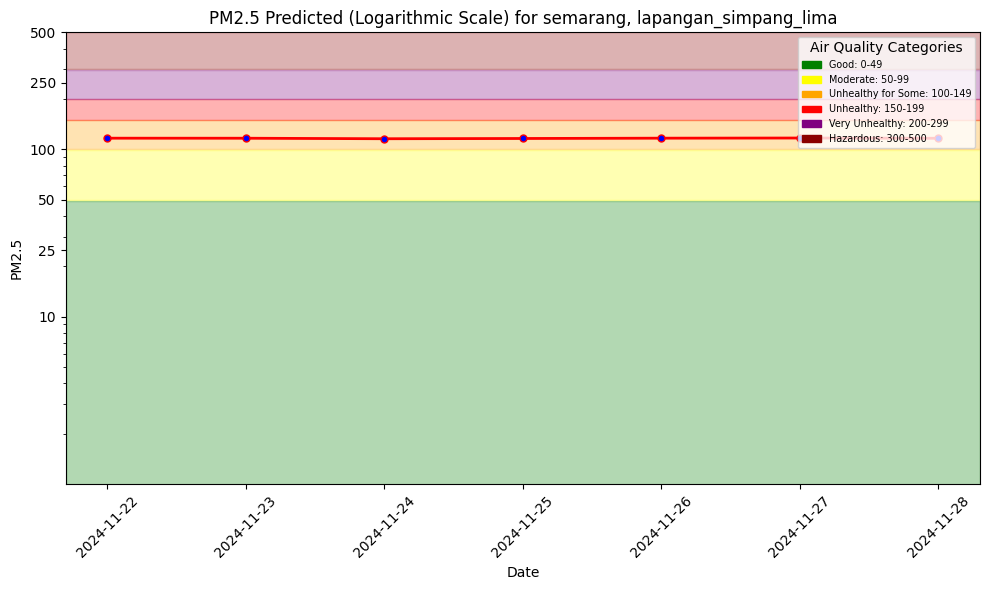

In [26]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [27]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_improved',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [ ]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

In [29]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
#monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
#monitoring_df

monitoring_df = monitor_fg.read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.45s) 


,date,pm25_rolling_mean_3d,pm25_rolling_mean_7d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_std_7d,pm25_rolling_max_7d,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,...,temp_wind_interaction,temp_precip_interaction,wind_direction_sin,wind_direction_cos,temp_wind_precip,high_temp_low_wind,wind_efficiency,predicted_pm25,city,days_before_forecast_day
0,2024-11-26 00:00:00+00:00,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.406748,90.695291,90.983834,...,138.366623,0.000000,0.554701,-8.320500e-01,0.000000,0,0.187776,115.405098,semarang,6
1,2024-11-27 00:00:00+00:00,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,90.118205,90.406748,90.695291,...,98.472977,13.100000,0.287349,-9.578259e-01,49.236488,0,0.138181,115.243080,semarang,7
2,2024-11-22 00:00:00+00:00,90.983834,90.406748,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,120.900185,5.310000,0.948683,-3.162293e-01,24.180038,0,0.165288,114.789825,semarang,2
3,2024-11-21 00:00:00+00:00,91.272377,90.695291,10.901878,101.714286,14.818812,117.142857,91.560920,91.560920,91.560920,...,245.216385,5.190000,0.761940,-6.476473e-01,49.043278,0,0.350633,114.390366,semarang,1
4,2024-11-25 00:00:00+00:00,90.118205,90.406748,10.901878,101.714286,14.818812,117.142857,90.695291,90.983834,91.272377,...,228.168610,2.705000,0.768222,-6.401838e-01,22.816862,0,0.300715,115.392380,semarang,5
5,2024-11-23 00:00:00+00:00,90.695291,90.406748,10.901878,101.714286,14.818812,117.142857,91.272377,91.560920,91.560920,...,121.217545,5.120000,0.988372,-1.520557e-01,24.243509,0,0.178010,115.476097,semarang,3
6,2024-11-28 00:00:00+00:00,89.829663,90.406748,10.901878,101.714286,14.818812,117.142857,89.829663,90.118205,90.406748,...,30.054283,2.640000,-0.948683,3.162291e-01,3.005429,0,0.041548,115.204140,semarang,8
7,2024-11-24 00:00:00+00:00,90.406748,90.406748,10.901878,101.714286,14.818812,117.142857,90.983834,91.272377,91.560920,...,210.236282,2.660000,0.865427,-5.010350e-01,21.023628,0,0.286363,115.393845,semarang,4
8,2024-11-27 00:00:00+00:00,90.281350,90.773007,10.001751,101.142857,15.902128,121.857143,90.773007,91.018836,91.264664,...,60.048500,7.815000,0.780869,6.246953e-01,18.014549,0,0.085217,115.871597,semarang,6
9,2024-11-26 00:00:00+00:00,90.527178,90.773007,10.001751,101.142857,15.902128,121.857143,91.018836,91.264664,91.510493,...,88.286362,2.660000,0.759258,-6.507903e-01,8.828636,0,0.120255,115.815918,semarang,5


In [30]:
air_quality_fg = fs.get_feature_group(
    name='air_quality_improved',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.62s) 


,date,pm25,country,city,street,url,pm25_rolling_mean_3d,pm25_rolling_std_3d,pm25_rolling_max_3d,pm25_rolling_mean_7d,...,pm25_ema_7d,pm25_trend_3d,pm25_volatility_3d,pm25_trend_7d,pm25_volatility_7d,pm25_trend_14d,pm25_volatility_14d,pm25_zscore,pm25_percentile,pm25_skew_7d
0,2023-05-31 00:00:00+00:00,105.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,108.666667,8.144528,118.0,111.571429,...,110.501333,-1.333333,0.074950,-5.928571,0.084374,16.678571,0.092975,0.720566,0.743028,-0.308756
1,2022-05-27 00:00:00+00:00,69.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,67.000000,7.211103,73.0,66.428571,...,67.243382,-2.333333,0.107628,-3.928571,0.153237,1.285714,0.209159,-0.943490,0.188247,-0.541525
2,2024-09-23 00:00:00+00:00,84.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,95.000000,11.000000,106.0,87.428571,...,90.384138,4.166667,0.115789,-1.642857,0.159975,-0.214286,0.139076,-0.250133,0.442231,-0.294547
3,2024-05-15 00:00:00+00:00,106.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,113.333333,10.214369,125.0,100.428571,...,106.031802,12.833333,0.090127,-8.357143,0.149123,14.571429,0.140902,0.766790,0.755976,0.218035
4,2022-04-14 00:00:00+00:00,98.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,104.666667,14.224392,121.0,92.000000,...,96.146481,10.166667,0.135902,2.785714,0.168858,-0.428571,0.146093,0.397000,0.662849,0.738984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,2024-08-11 00:00:00+00:00,97.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,98.666667,1.527525,100.0,105.285714,...,101.264014,-7.666667,0.015482,6.142857,0.089219,-7.428571,0.186273,0.350776,0.646912,0.777546
1002,2024-05-11 00:00:00+00:00,86.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,88.666667,10.263203,100.0,106.000000,...,98.878288,-14.666667,0.115750,2.571429,0.169899,15.928571,0.165072,-0.157686,0.470618,-0.353569
1003,2023-04-13 00:00:00+00:00,61.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,72.000000,10.148892,81.0,80.142857,...,78.644753,-7.000000,0.140957,-5.571429,0.140511,-6.642857,0.226337,-1.313280,0.086155,-0.415397
1004,2024-11-20 00:00:00+00:00,75.0,indonesia,semarang,lapangan_simpang_lima,https://api.waqi.info/feed/@13651,74.000000,12.529964,86.0,87.142857,...,84.542559,-18.833333,0.169324,-8.785714,0.308091,-0.928571,0.234294,-0.665056,0.287276,0.235102


In [32]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df = monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df


,date,predicted_pm25,pm25
0,2024-11-21 00:00:00+00:00,114.390366,92.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [ ]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---